# Generating building blocks from a list of smiles

In this notebook we show how we can generate a list of building blocks from a list of smiles in an csv file

the first step is to generate a list of building block with defined connection points for the building bloakc from a set of fragment following some rules

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

from stk_search.Precursors import precursor_database_utils as pdu


In [2]:
# load a dataframe with a list of fragments as smiles
df_unit_polymer=pd.read_csv("data_example/fragment/classification_unit_A_or_D.csv")
df_unit_polymer.head()

,Unnamed: 0,fragment_number,smi_filename,smiles,sTDDFTxtb_HOMO,B3LYP_HOMO,A_or_D
0,0,0,0_TL.smi,C(=C1C(=O)c2cc(F)c(F)cc2C1=C(C#N)C#N),-16.456,-7.491072,A
1,1,1,1_TL.smi,C(=C1C(=O)c2ccccc2C1=C(C#N)C#N),-16.284,-7.364308,A
2,2,10,10_TL.smi,C(=C1C(=O)N(CC)C(=S)N(CC)C1=O),-14.764,-6.244068,D
3,3,100,100_C.smi,c1cc2C(CC)(CC)c3c(-c2cc1)ccc(c3),-15.072,-6.471064,D
4,4,101,101_C.smi,c1cc2C(=O)NC(=O)c3cc(cc(c1)c23),-15.743,-6.965591,A


715
439
159


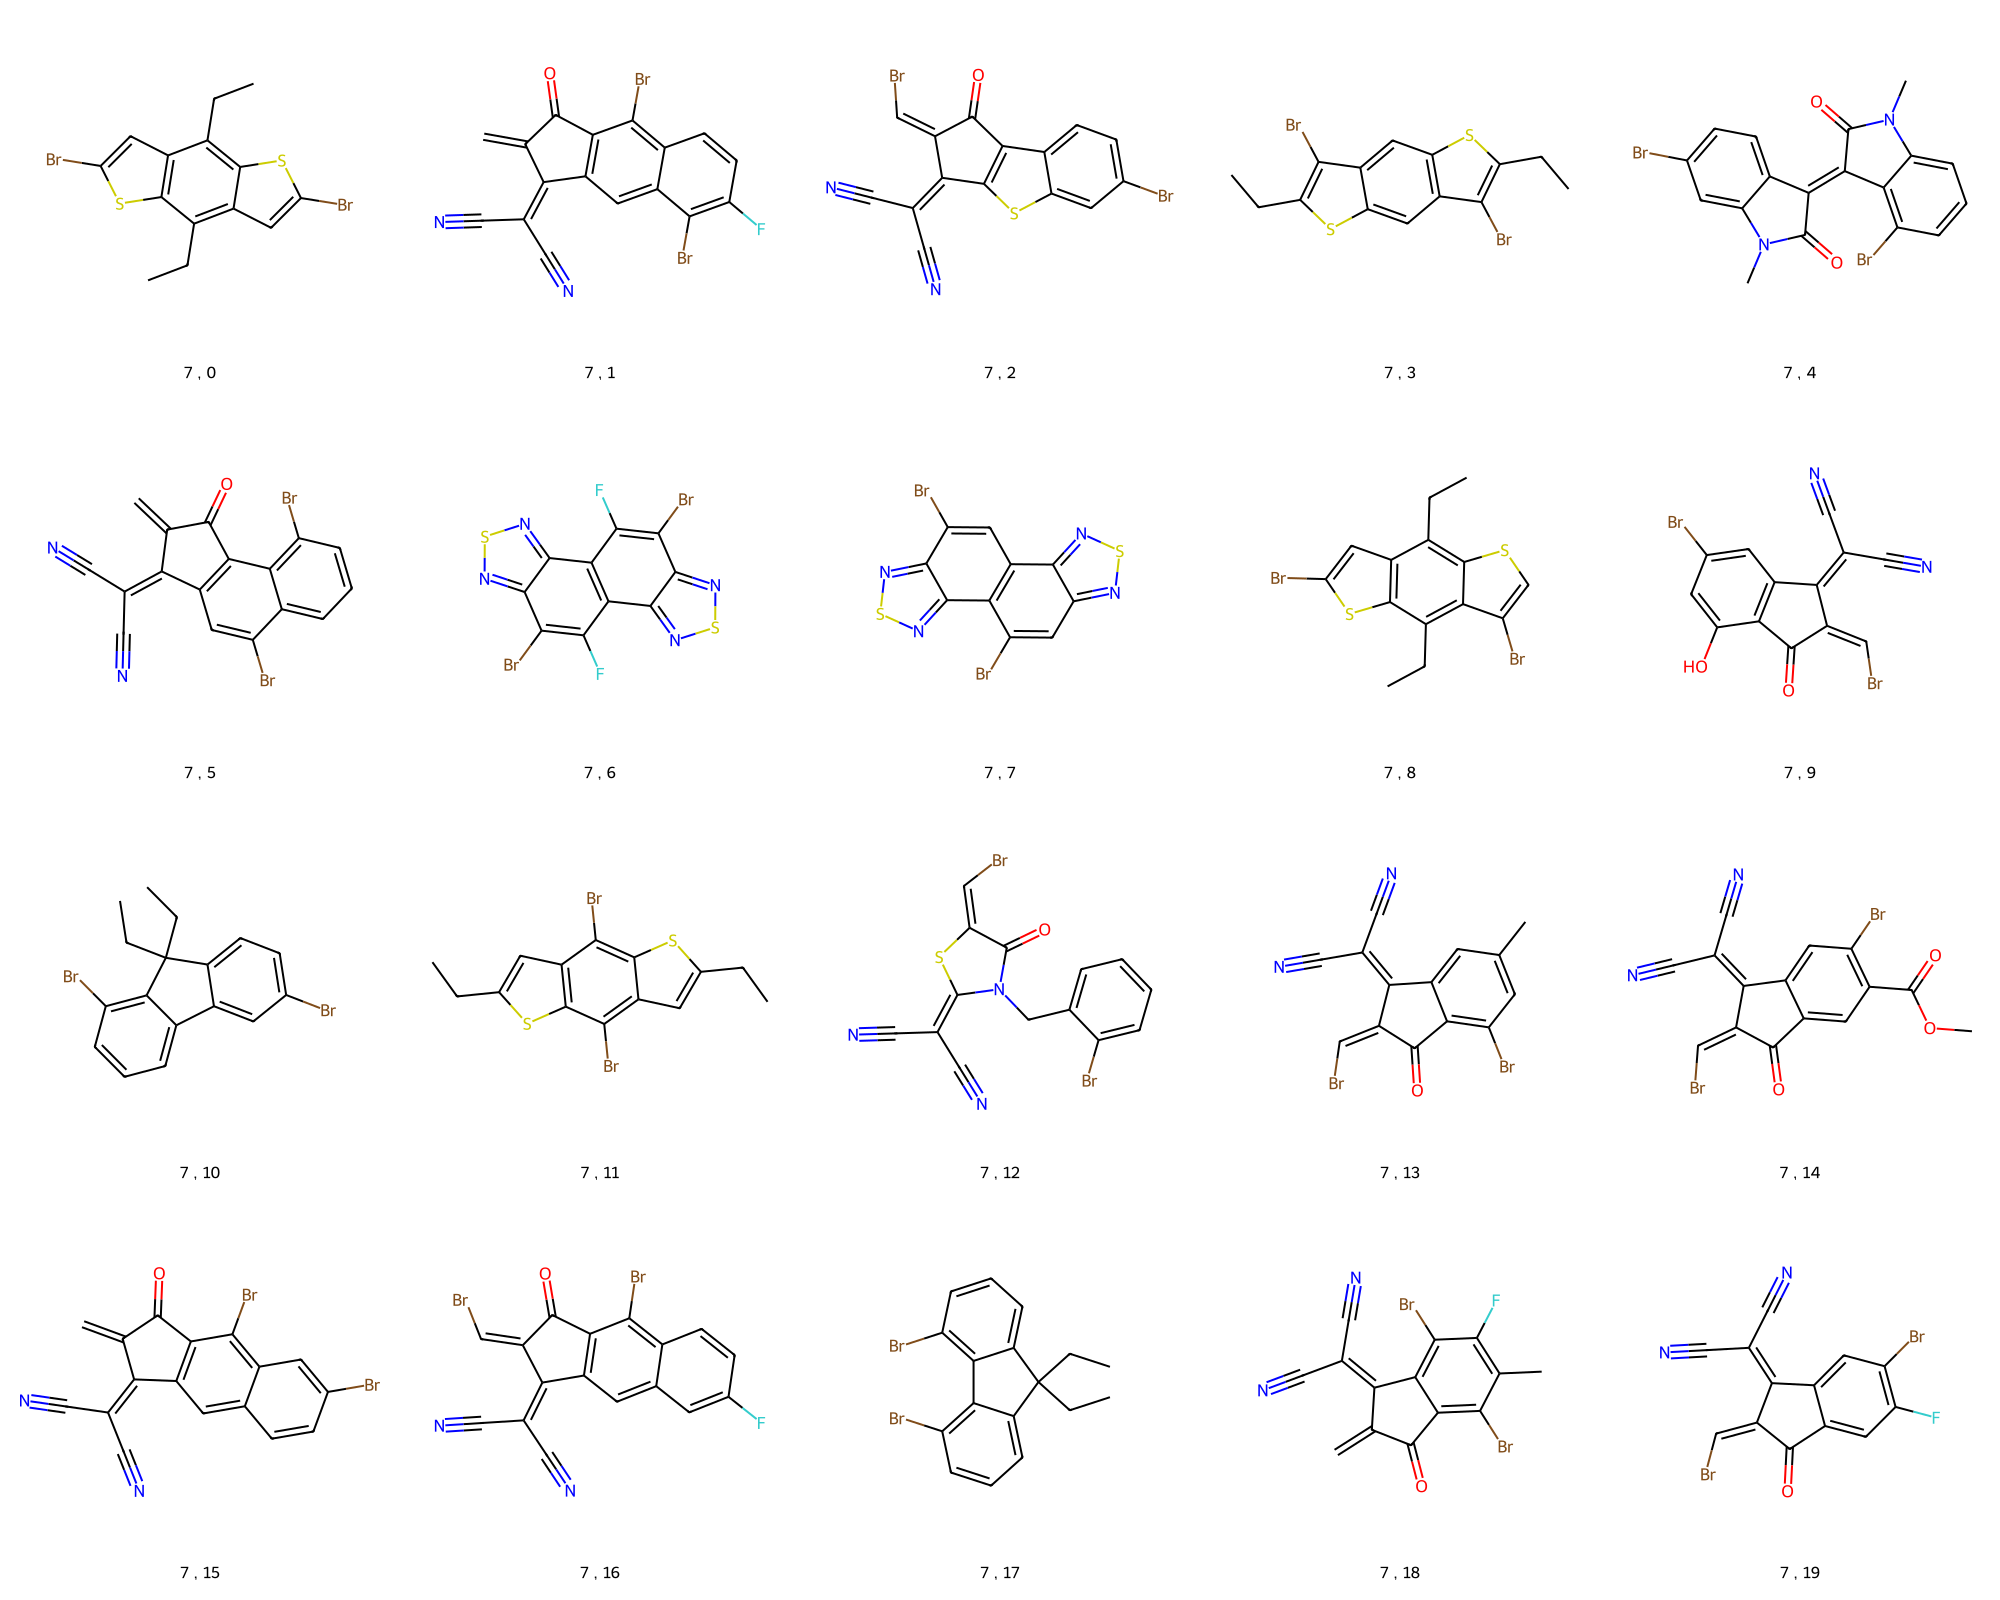

In [3]:
mol_list_smiles_all=[]
mol_list_all=[]
org_smiles=[]

for _count,smiles in enumerate(df_unit_polymer["smiles"]):
    mol=Chem.MolFromSmiles(smiles)
    if mol.GetNumAtoms()<30:
        mol_list,mol_list_smiles,smile=pdu.fragment_from_smiles(smiles)
        mol_list_smiles_all+=mol_list_smiles
        mol_list_all+=mol_list
        org_smiles+=smile
print(len(mol_list_smiles_all))
mol_list_all = [Chem.MolFromSmiles(smile) for smile in set(mol_list_smiles_all)]
mol_list_all_org = [Chem.MolFromSmiles(smile) for smile in set(org_smiles)]
print(len(set(mol_list_smiles_all)))
print(len(set(org_smiles)))
img=Draw.MolsToGridImage(mol_list_all[:20],molsPerRow=5,subImgSize=(400,400),returnPNG=False,legends=[f"7 , {index}" for index, x in enumerate(mol_list_all)])    
img


Here we show the different building blocks from the same fragment

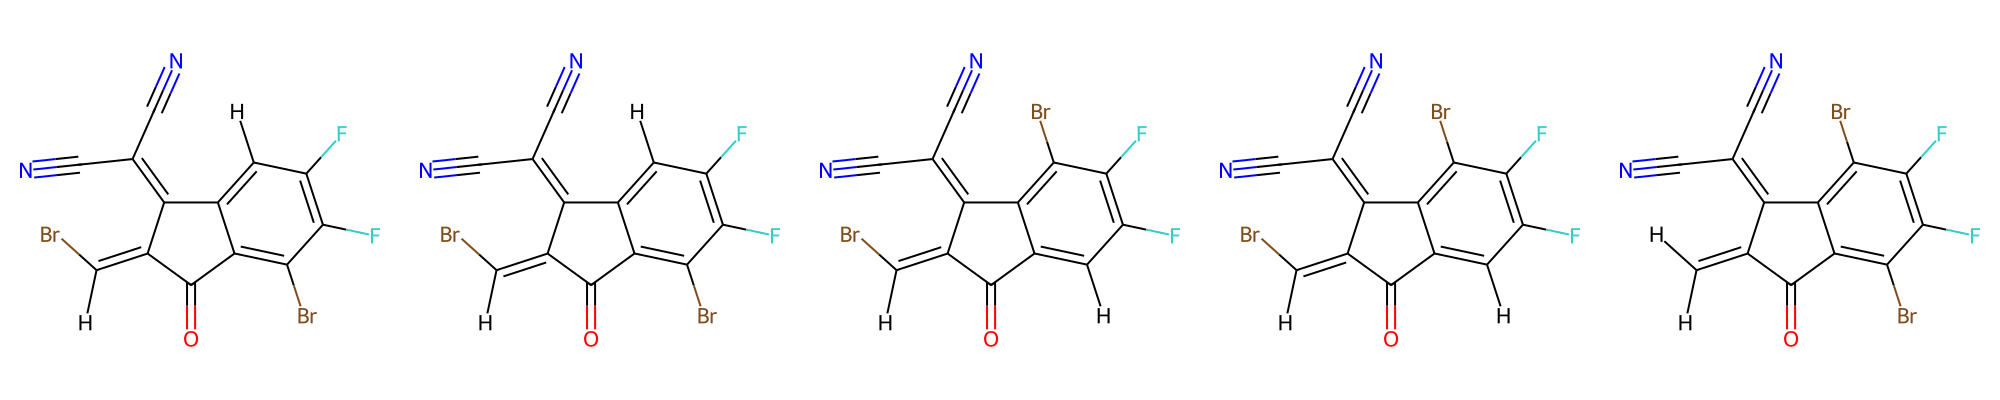

In [4]:
for _count,smiles in enumerate(df_unit_polymer["smiles"]):
    mol=Chem.MolFromSmiles(smiles)
    if mol.GetNumAtoms()<30:
        mol_list,mol_list_smiles,smile=pdu.fragment_from_smiles(smiles)
        break
img=Draw.MolsToGridImage(mol_list,molsPerRow=5,subImgSize=(400,400),returnPNG=False)    
img

In [5]:
# save a list of smiles into a file
with Path("data_example/fragment/fragementclean_test.txt").open("w") as f:
    for item in set(mol_list_smiles_all):
        f.write("%s\n" % item)

## calculate the properties of for the building blocks and add them to the database
 this part is necessary to add the building block to the molecules database, so that we can load the building blocks to build the oligomers from there
 


In [6]:
precursor_database = pdu.PrecursorDatabase(client_address = "mongodb://localhost:27017/", database_name = "stk_precursor")
precursor_database.collection_name = "Precursors"

In [7]:
#test adding building block to database
precursor_database.add_precursor_to_database(mol_list_smiles[0])


BuildingBlock('N#CC(C#N)=C1C(=CBr)C(=O)c2c1cc(F)c(F)c2Br', (Bromo(Br(1), C(0), bonders=(C(0),), deleters=(Br(1),)), Bromo(Br(7), C(6), bonders=(C(6),), deleters=(Br(7),))))

In [8]:
precursor_database.xtb_path ="xtb"
precursor_database.host_ip = "local_test"
precursor_database.stda_bin_path = "/media/mohammed/Work/bin/"
precursor_database.database_output_folder = (
            "data/xtb_calculation/"
        )
ES1 = precursor_database.evaluate_element(mol_list_smiles_all[3])
print(ES1)

normal termination of xtb
/bin/sh: 1: /media/mohammed/Work/bin//stda_v1.6.1: not found
ERROR:root:Error connecting to stda %s
Traceback (most recent call last):
  File "/media/mohammed/Work/STK_search/src/stk_search/ObjectiveFunctions/IpEs1Fosc.py", line 168, in test_xtb_stda_connection
    subprocess.run(command, check=True, shell=True)  # noqa: S602
  File "/media/mohammed/Work/anaconda3/envs/stk_search/lib/python3.8/subprocess.py", line 516, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command '/media/mohammed/Work/bin//stda_v1.6.1 --version' returned non-zero exit status 127.


      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

(-6.683777299437136, 'HNRHIGPDSSXEJA-UQCOIBPSSA-N')


In [9]:
precursor_database.extra_collections = []
df_precursor = precursor_database.load_data()

In [10]:
collection_name = "Precursors"
precursor_database.extra_collections = [collection_name+"_IPEA",collection_name+"_opt",collection_name+"_Stda"]
df_precursor = precursor_database.load_data()

In [32]:
import pymongo
import stk


def Inch_to_mol(InChIKey, client = "mongodb://localhost:27017/"
              , database = "stk_precursor"):
    """ 
    This function takes an InChIKey and returns the RDKit molecule

    Parameters
    ----------
    InChIKey : str
        InChIKey
    client : str
        client address
    database : str
        database name

    Returns
    -------
        mol : RDKit molecule
        RDKit molecule

    """
    client = pymongo.MongoClient(client)
    db = stk.MoleculeMongoDb(client, database=database)
    stk_mol = db.get( {"InChIKey": InChIKey})
    mol = stk_mol.to_rdkit_mol()
    Chem.SanitizeMol(mol)
    return mol

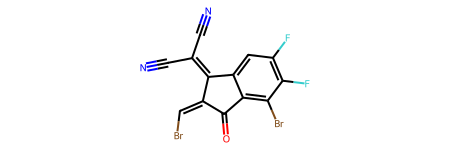

In [33]:
mol = Inch_to_mol(df_precursor["InChIKey"].iloc[0])
Chem.MolFromSmiles(Chem.MolToSmiles(mol))


# Generate a df_precursor with the properties of the fragment to include in the oligomer representation

The generation of the dataframe with the building block properties for the Representation need the mongodb database to contain the fragments

In [46]:
# case of fragment properties
numeric_columns = df_precursor.select_dtypes(include= ["int", "float"]).columns
df_properties = df_precursor[numeric_columns]
df_properties["InChIKey"] = df_precursor["InChIKey"].copy()
df_properties["mol_opt"] = df_properties["InChIKey"].apply(Inch_to_mol)
df_properties["Atom_num"] = df_properties["mol_opt"].apply(lambda x: x.GetNumAtoms())
print("shape of the dataframe", df_properties.shape)


/tmp/ipykernel_2871937/2735123356.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties["InChIKey"] = df_precursor["InChIKey"].copy()


shape of the dataframe (459, 9)


/tmp/ipykernel_2871937/2735123356.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties["mol_opt"] = df_properties["InChIKey"].apply(Inch_to_mol)
/tmp/ipykernel_2871937/2735123356.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties["Atom_num"] = df_properties["mol_opt"].apply(lambda x: x.GetNumAtoms())


In [47]:
print("shape of the dataframe", df_properties.shape)


shape of the dataframe (459, 9)


In [35]:
df_properties[df_properties["Atom_num"]<30]
def check_mol(mol):
    if mol.GetNumAtoms()>=30:
        return 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() ==14:
            return 0
        if atom.GetAtomicNum() ==32:
            return 0
    return 1
df_properties["check"] = df_properties["mol_opt"].apply(check_mol)
df_properties = df_properties[df_properties["check"]==1]
df_properties.drop(columns=["check"], inplace=True)
df_properties.shape

/tmp/ipykernel_2871937/3160104987.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_properties["check"] = df_properties["mol_opt"].apply(check_mol)


(313, 9)

In [36]:
df_properties_path = "data_example/precursor/df_properties.pkl"
os.makedirs(os.path.dirname(df_properties_path), exist_ok=True)
df_properties.to_pickle(df_properties_path)

In [37]:
# case of mordred descriptors
from mordred import Calculator, descriptors
from sklearn.decomposition import PCA
calc = Calculator(descriptors, ignore_3D=False)
df_precursor["mol_opt"] = df_precursor["InChIKey"].apply(Inch_to_mol)


In [39]:
descriptors_df = calc.pandas(df_precursor["mol_opt"])
descriptors_df["InChIKey"] = df_precursor["InChIKey"]
descriptors_df.dropna(inplace=True)
PCA_model = PCA(n_components=10)
frag_properties = descriptors_df.select_dtypes(include=[np.number]).columns 
X_PCA = PCA_model.fit_transform(descriptors_df[frag_properties].values)
df_representation = pd.DataFrame(X_PCA, columns=[f"PCA_{i}" for i in range(X_PCA.shape[1])])
df_representation["InChIKey"] = descriptors_df["InChIKey"]

100%|██████████| 459/459 [00:07<00:00, 57.80it/s] 


In [40]:
df_representation_path = "data_example/precursor/df_mordred_24072024.pkl"
os.makedirs(os.path.dirname(df_representation_path), exist_ok=True)
df_representation.to_pickle(df_representation_path)